# Multi-Class Object Detector with Hyperparameter Tuning
Using Faster R-CNN (ResNet50) trained on COCO dataset. From FAIR Detectron

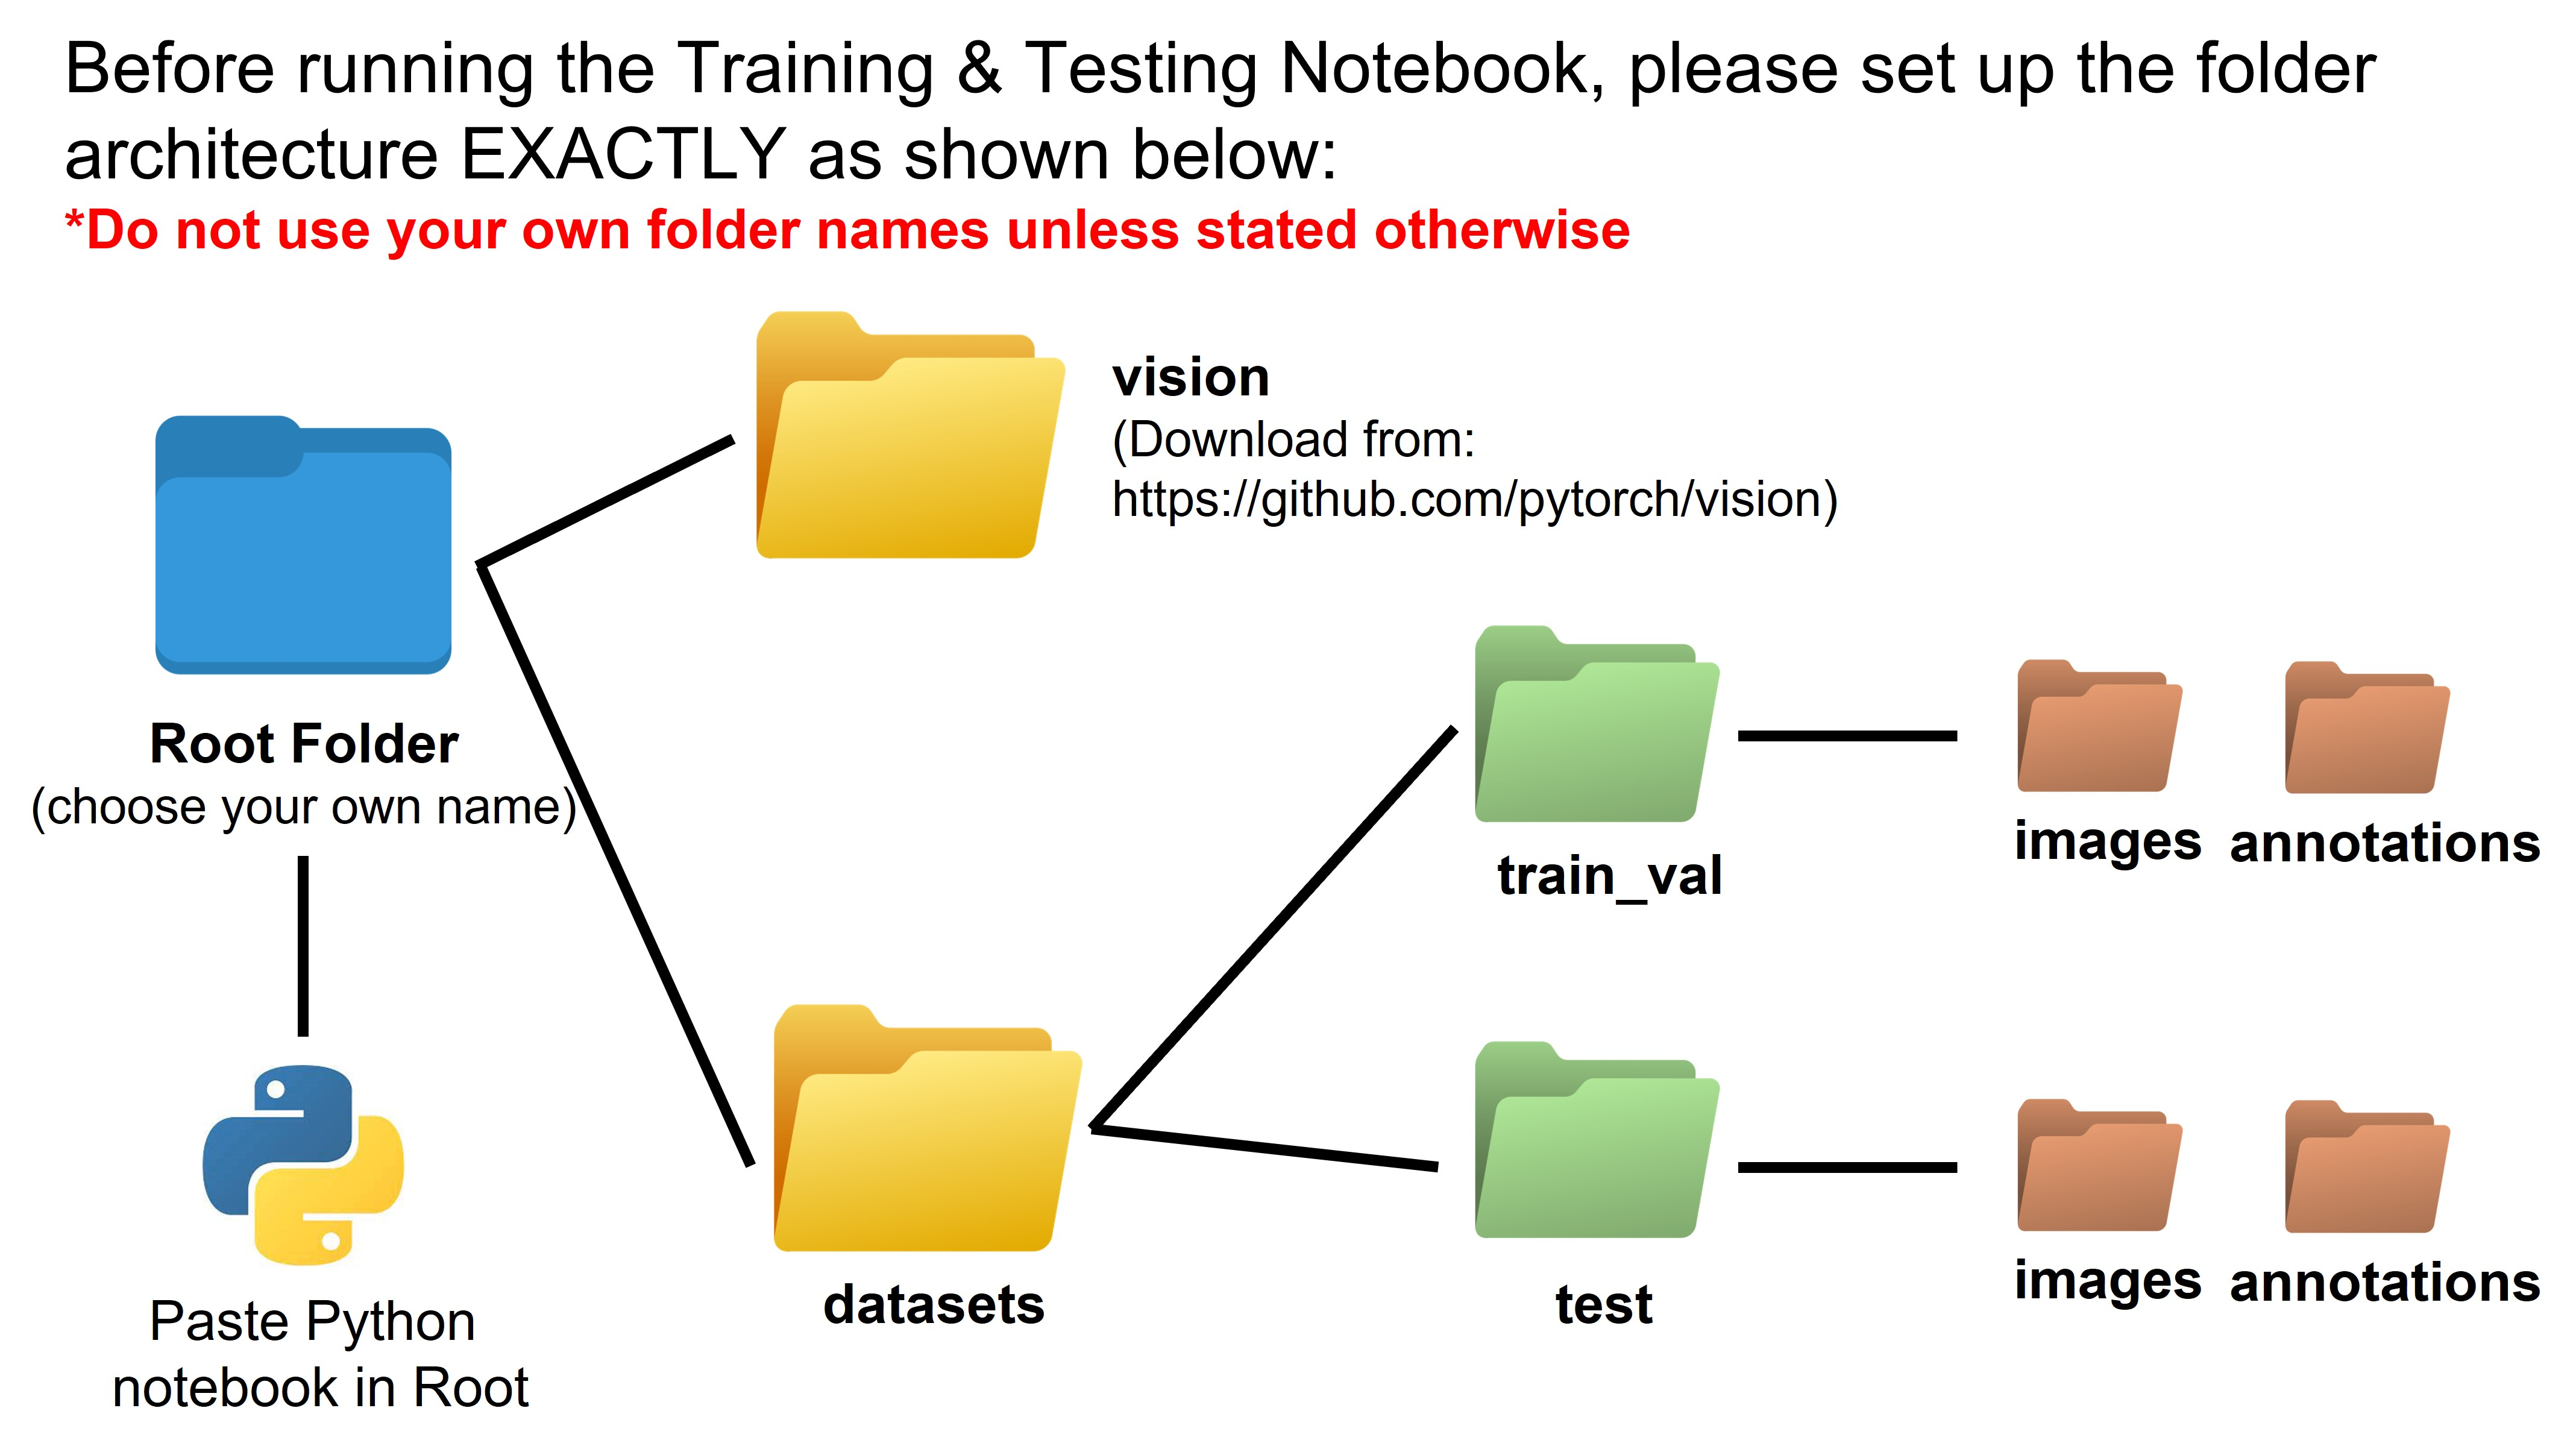

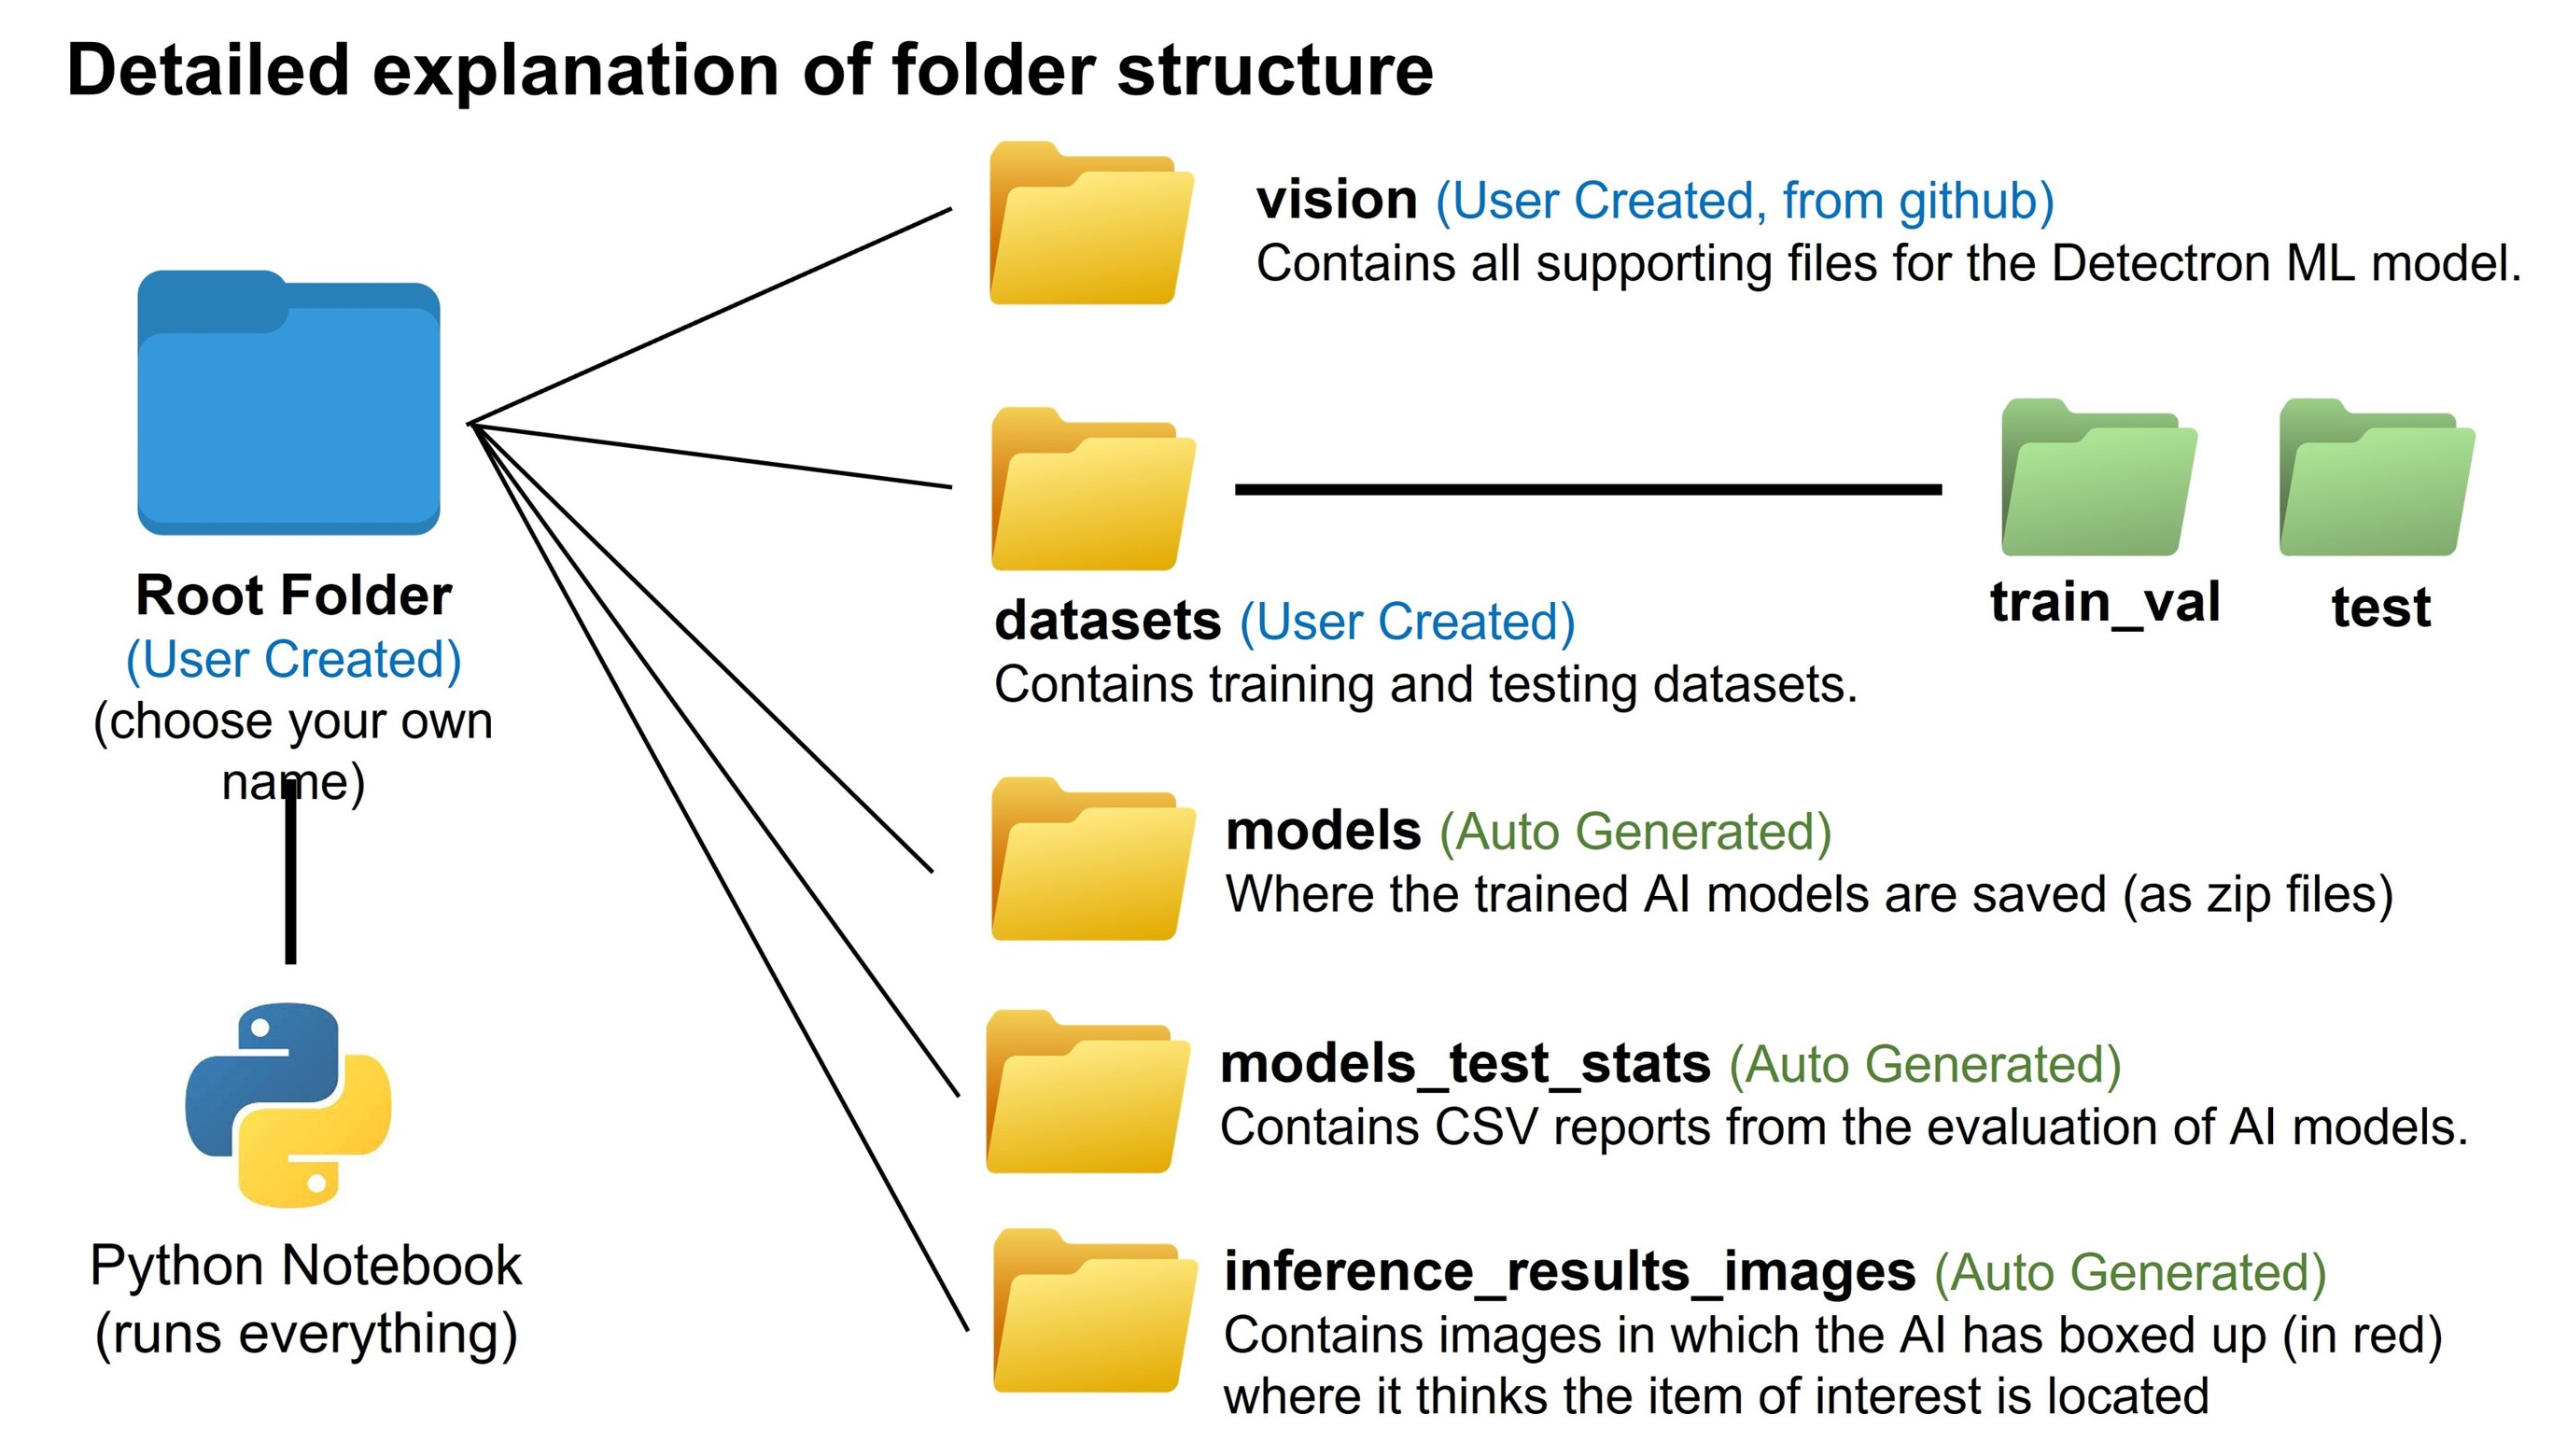

---

# *** These cells will run the entire process ***
## IMPT: For EVERY NEW DATASET, Comment out 2nd-4th blocks of code below first and run all, then run the relevant cells last!

In [ ]:
experiment_title = "experiment_1"

# Training Code

In [ ]:
# run_entire_programme(experiment_title)

# Inference Code
## Run this if your test dataset is labelled

In [ ]:
# model_to_use = f"model_{experiment_title}_0"

# run_inference(model_to_use)

## Run this if your test dataset is not labelled
Note: All test images to be stored in "images" folder under test directory.

In [ ]:
# model_to_use = f"model_{experiment_title}_0"

# run_inference_unlabelled(model_to_use)



---


# PART 1: SET UP
## Follow the next few steps and you're (hopefully) done

### Note: Any directories with "#CHANGE_ME" needs to be changed to suit dataset.

## STEP 1: Specify Root Directory

In [ ]:
import os, sys

# ROOT DIRECTORY in which datasets/models will be built in
root = 'your/root/here'                   # CHANGE_ME
os.chdir(root)
os.getcwd()

## STEP 2: Specify test and training directories

In [ ]:
# Relative to root directory!

dataset_directory = f"{root}/datasets"
dataset_subfolders = ['train_val', 'test']                    

In [ ]:
train_directory = os.path.join(dataset_directory, dataset_subfolders[0])
test_directory = os.path.join(dataset_directory, dataset_subfolders[1])
directories_list = [train_directory, test_directory]     

## STEP 3: SPECIFY CONSTANTS AND HYPERPARAMETERS 

In [ ]:
# GROUP 1: USER-DEFINED CONSTANTS

# DATALOADER
# Determine number of subprocesses for dataloader
# 2 is recommended, but 4 still works. Too high may cause slow-down
num_workers = 0

# Seed for randomly splitting train and validation set
random_seed = 1504

# OPTIMIZER
decay = 0.0005
mmtm = 0.9              # Momemtum for SGD

# LR SCHEDULER FOR SGD
stp = 3                 # Decreases learning rate every 3 epochs
gma = 0.1               # Gamma - 0.1 means decrease lr by 10x

# TRAINING
printing_freq = 50      # Frequency of displaying results (per how many images?) (THIS IS NOT BATCH SIZE!)
percentage_val = 0.2    # % of dataset to use as validation (e.g. 0.2 = 20% val, 80% train)

# TESTING
# Required CONF threshold to draw box and be certain of right detection
# Put lower threshold if model is highly accurate
threshold = 0.8

###################################################################

# GROUP 2: HYPERPARAMETER TUNING

# Hyperparameter tuning:
# IF TRUE, USE GROUP 2. IF FALSE, GO TO GROUP 3. 
perform_tuning = False        # True to tune. False to not use SGD and default values below.


# ***IGNORE this if not doing hyperparameter tuning!***
# Number of epochs to train for (put list to train for varying epochs)
num_epochs_list = [8, 10, 12]

# OPTIMIZER
# Type of optimizer
# Available options: ['SGD', 'Adam', 'Adadelta', 'RMSProp']
optimizers_list = ['SGD']

# Learning Rate
lr_SGD = [1e-2, 1e-1, 2e-1]    # Default is 1e-3 or 1e-2
lr_Adam = [1e-2, 1e-1]         # Default is 1e-3
lr_Adadelta = [1e-1, 1]        # Default is 1
lr_RMSProp = [1e-3]            # Default is 1e-2


# Batch size - too large may cause running out of memory!
batch_size_list = [2, 4, 6]

######################################################################

# default values (for no hyperparameter tuning)
default_epoch = 10
default_lr = 1e-2
default_batch_size = 2     # Train_batch_size scales with 2*scale factor and test_batch_size scales with 1*scale factor
default_optim = 'SGD'



---


## No more editing from here on! Skip to "testing" section to input your own custom test images

---
# Import Libraries

In [ ]:
import torch
import torchvision
torch.cuda.empty_cache()

### Check if cuda is available

In [ ]:
torch.cuda.is_available()

In [ ]:
print(torch.__version__)

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time as time
import math
import glob
import xml.etree.ElementTree as ET
from PIL import ImageFont, ImageDraw, Image
import datetime
from datetime import datetime as DT

## Import ML libraries

In [ ]:
os.chdir(root)

from shutil import copy, copytree
vision_root = os.path.join(os.path.dirname(root), "vision")

# Copy over vision folder to root if it does not exist!
if not os.path.exists(os.path.join(root, "vision")):
    copytree(vision_root, os.path.join(root, "vision"))

In [ ]:
# Copy some py files for importing later

copy("vision/references/detection/utils.py", "vision")
copy("vision/references/detection/transforms.py", "vision")
copy("vision/references/detection/coco_eval.py", "vision")
copy("vision/references/detection/engine.py", "vision")
copy("vision/references/detection/coco_utils.py", "vision")

In [ ]:
os.chdir(os.path.join(root, "vision")) 

from engine import train_one_epoch, evaluate
import utils
import transforms as T    # For flipping images etc

# from torchvision import transforms as T   
# import torchvision.transforms as T

os.chdir("..")

In [ ]:
import torch
import torchvision
import torch.utils.data

# Import selected model - Faster R-CNN ResNet-50 FPN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
# This is used to prevent printing of reports during training to be more neat
# Use example:
# with HiddenPrints():
#  print("This will not print")
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# PART 2: LOAD ML LIBRARIES AND MODELS

In [ ]:
# Retrieves the correct learning rate based on the Optimiser the user has selected

def retrieve_lr_list(curr_optim):
    input_list = ['SGD', 'Adam', 'Adadelta', 'RMSProp']
    output_list = [lr_SGD, lr_Adam, lr_Adadelta, lr_RMSProp]
    
    index = input_list.index(curr_optim)
    return output_list[index]

## Create Test Results folder to store csv of tests

In [ ]:
# Create Folder for Object Detection model and files (torchvision)
results_directory = f"{root}/performance_stats"

if not os.path.exists(results_directory):
    os.mkdir(results_directory)

# Set up Faster R-CNN ResNet50 FPN Model
Transfer Learning via finetunning from pretrained model on COCO

In [ ]:
# Create Folder for Trained Model
models_directory = f"{root}/models"

if not os.path.exists(models_directory):
    os.mkdir(models_directory)

if not os.path.exists(os.path.join(models_directory, f"model_{experiment_title}_data")):
    os.makedirs(os.path.join(models_directory, f"model_{experiment_title}_data"))

In [ ]:
# Set up model with required no. of classes

def get_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

---
# PART 3: PRE-PROCESS DATA

## Get xml labels and convert to csv, then pandas df

In [ ]:
# Function to convert xml to csv

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [ ]:
# Convert xml files to csv
ds_old = 0

# CSV Save dir
csv_save_dir = os.path.join(models_directory, f"model_{experiment_title}_data")
                            
for i, ds in enumerate(directories_list):
  if ds_old != ds:      # If statement to check if directories are repeated
    image_path = os.path.join(ds, 'annotations')
    xml_df = xml_to_csv(image_path)
    
    # Save CSV file into models directory
    xml_df.to_csv(os.path.join(csv_save_dir, f"labels_{dataset_subfolders[i]}.csv"))
    
    print('Successfully converted xml to csv. Output file in ROOT directory')
    ds_old = ds

In [ ]:
# Convert to pandas dataframe and check if correct
# Note: Make sure to import all (train, dev, test) CSVs

train_labels_savefile = os.path.join(csv_save_dir, f"labels_{dataset_subfolders[0]}.csv")
test_labels_savefile = os.path.join(csv_save_dir, f"labels_{dataset_subfolders[1]}.csv")

train_labels_df = pd.read_csv(train_labels_savefile)   
test_labels_df = pd.read_csv(test_labels_savefile) 

In [ ]:
train_labels_df

In [ ]:
test_labels_df

In [ ]:
# Replace class labels with numbers

# Get list of classes in dataframe, including "0" background layer
list_of_classes = np.array([0])
temp_class_list = np.unique(train_labels_df["class"])

# Sort in alphabetical order to ensure consistency.
temp_class_list = sorted(temp_class_list)
list_of_classes = np.append(list_of_classes, temp_class_list).astype(object)

# Get number of classes, including bg class
num_classes = len(list_of_classes)

# Map class names to numbers (e.g. 0 = background, 1 = flammable etc..)
for j in range(len(train_labels_df["class"])):
  class_index = np.where(list_of_classes == train_labels_df["class"][j])[0][0]
  train_labels_df.at[j,"class"] = class_index

for k in range(len(test_labels_df["class"])):
  class_index = np.where(list_of_classes == test_labels_df["class"][k])[0][0]
  test_labels_df.at[k,"class"] = class_index

In [ ]:
list_of_classes

In [ ]:
# Check if class replaced correctly
train_labels_df.head()

In [ ]:
test_labels_df.head()

# Extract coordinates of box and class label

In [ ]:
# Function to extract data labels
# "labels" from previously read pandas df of csv file

def parse_one_annot(path_to_data_file, filename):
  if path_to_data_file == train_labels_savefile:
    target_row = train_labels_df[train_labels_df["filename"] == filename]                 # Extracts one row matching "filename"
  elif path_to_data_file == test_labels_savefile:
    target_row = test_labels_df[test_labels_df["filename"] == filename]                 # Extracts one row matching "filename" 
       
  boxes_array = target_row[["xmin", "ymin", "xmax", "ymax"]].values         # Extracts bounding coords from that row
  class_type = target_row[["class"]].values
   
  return boxes_array, class_type.astype(str).astype(int)

---

# PART 4: Set up Custom Dataset Class
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

ataset should inherit from the standard torch.utils.data.

Dataset class, and implement _ _ len _ _ and _ _ getitem _ _


"_ _ getitem _ _" should return:



1. PIL Image of size (Height, Width)
2. target: a dict with the following fields:
    * __boxes__ (FloatTensor[N, 4]): coordinates of the N bounding boxes in [x0, y0, x1, y1] format
    * __labels__ (Int64Tensor[N]): label (e.g. raccoon) for each bounding box. 0 represents always the background class.
    * __image_id__ (Int64Tensor[1]): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * __area__ (Tensor[N]):  area of the bounding box. Used to separare small/medium/large boxes in mAP
    * __iscrowd__(UInt8Tensor[N]) - 8-bit integer (unsigned): instances with iscrowd=True will be ignored during evaluation




In [ ]:
class MyCustomDataset(torch.utils.data.Dataset):
  # Transforms is for data augmentation, by default None but a transforms helper fn is used (see below)
  
  def __init__(self, root, data_file, transforms=None):
    self.root = root
    self.transforms = transforms
    self.imgs = sorted(f for f in os.listdir(
        os.path.join(root, "images")) if os.path.isfile(
        os.path.join(root, "images", f)))
    
    self.path_to_data_file = data_file


  # Get image information, returning required tensor "target"
  def __getitem__(self, idx):

    # PART 0: GET IMAGE PIL FILE
    # load EACH image and its bounding boxes
    img_path = os.path.join(self.root, "images", self.imgs[idx])        # Get address of each image
    img = Image.open(img_path).convert("RGB")                           # Open image and convert to RGB
  
    # PART 1: GET COORDS OF BOUNDING BOXES   
    box_list, class_type_num = parse_one_annot(self.path_to_data_file,                  # Get bounding box coords for this image
    self.imgs[idx])
    boxes = torch.as_tensor(box_list, dtype=torch.float32)              # Convert array of coords to tensor

    # PART 2: GET CLASS LABELS
    # To handle multiple classes
    class_type_num = class_type_num.transpose()[0] 
    labels = torch.as_tensor(class_type_num, dtype=torch.int64)
    
    # PART 3: GET IMAGE_IDs
    image_id = torch.tensor([idx])

    # PART 4: COMPUTE AREA
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])

    # PART 5: suppose all instances are not crowd so none will be ignored
    num_objs = len(box_list)
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    # ASSEMBLE REQUIRED TARGET DICTIONARY
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd


    if self.transforms is not None:
        img, target = self.transforms(img, target)
    return img, target


  def __len__(self):
    return len(self.imgs)

In [ ]:
# Testing if the above works - should return tuple with 1. PIL image 2. target dict

# Define dataset (images) and labels location for train
dataset = MyCustomDataset(root= train_directory, 
                        data_file= train_labels_savefile)

# Test if successful
dataset.__getitem__(2)

---
# PART 5: DATA AUGMENTATION, DATALOADER

# Data Augmentation to broaden dataset


*   Horizontal Flip
*   ColorJitter (Brightness, Contrast, Saturation)
*   Random IOU Crop


In [ ]:
def augment_image(train):
    # Create new list of original and transformed images
    transforms = []

    # converts the PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())

    # Augments image only if during training stage; train == True:
    if train:
      # Randomly augment the training images and ground-truths for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
#         transforms.append(T.RandomPhotometricDistort())
#         transforms.append(T.RandomIoUCrop())
    return T.Compose(transforms)

# Prepare train, validate, test datasets

In [ ]:
def split_train_data():
  # Get training dataset
  dataset_train = MyCustomDataset(root= train_directory, 
                          data_file= train_labels_savefile, 
                          transforms = augment_image(train=True))


  # Get testing dataset - same as that for training BUT no augmentation. 
  dataset_val = MyCustomDataset(root= train_directory, 
                          data_file= train_labels_savefile, 
                          transforms = augment_image(train=False))

  # Split the dataset into train and test set
  torch.manual_seed(random_seed)     # Set my own seed for random number generation for consistency

  # Randomly mix up numbers from 1 to length of dataset
  indices = torch.randperm(len(dataset_train)).tolist()

  # Take 20% test, 80% train split
  num_val = math.floor(len(dataset_train)*percentage_val)

  dataset_train = torch.utils.data.Subset(dataset_train, indices[:-num_val])
  dataset_val = torch.utils.data.Subset(dataset_val, indices[-num_val:])

  print(f"We have: {train_labels_df.shape[0]} objects in {len(indices)} images, {len(dataset_train)} are training images and {len(dataset_val)} validation images")

  return dataset_train, dataset_val

In [ ]:
def load_test_data():
  dataset_test = MyCustomDataset(root= test_directory, 
                        data_file= test_labels_savefile, 
                        transforms = augment_image(train=False))
  return dataset_test

---

# PART 6: TRAIN, TEST, SAVE MODEL

## Function to Train, Test, Analyse, Save Model

In [ ]:
def train_test_analyse(num_epochs, curr_lr, curr_batchsize, curr_optim, 
                       datasets, curr_it, results_df, experiment_title):
  """
  Performs one round of training (+validation) and testing for given hyperparameters

  Input:
  1. num_epoch: Number of epochs to train for

  2. curr_lr: Learning rate for current run
  
  3. curr_batch_size: DataLoader batch size for current run

  4. curr_optim: Optimizer to use for current run

  5. datasets (train, val, test - unseen)

  6. curr_it: Tracks current test cycle 

  7. experiment_title: Name of current experiment (user defined)


  Output files:
    1. Trained Model
    2. Tensorboard File for validation dataset

  Returns:
    1. curr_it - iteration count
    2. results_df containing:
      a. Hyperparameters for this test
      b. mAP, AR, Loss of Validation Dataset
      c. mAP, AR, Loss of UNSEEN test Dataset
      d. Mean Max CONF score of test Dataset (KIV)

  """
  print("\n**************************************************************\n")

#   ## Prepare writer for tensorboard
#   writer = SummaryWriter(
#       f"{experiment_title}_run{curr_it}")

  ## Create new model & move to device
  model = get_model(num_classes)
  model.to(device)


  ## Optimizers
  SGD_Flag = False
  params = [p for p in model.parameters() if p.requires_grad]

  # Option 1: Adam
  if curr_optim == 'Adam':
    print(f"Training with Adam optim with lr={curr_lr}, batchsize={curr_batchsize}")
    optimizer = torch.optim.Adam(params, lr=curr_lr)

  # Option 2: Adadelta
  elif curr_optim == 'Adadelta':
    print(f"Training with Adadelta optim with lr={curr_lr}, batchsize={curr_batchsize}")
    optimizer = torch.optim.Adadelta(params, lr=curr_lr)

  # Option 3: RMSProp
  elif curr_optim == 'RMSProp':
    print(f"Training with RMSProp optim with lr={curr_lr}, batchsize={curr_batchsize}")
    optimizer = torch.optim.RMSprop(params, lr=curr_lr)

  # Option 4 (Default): SGD + Manual LR Scheduler to decrease LR
  else:
    print(f"Training with SGD optim with lr={curr_lr}, batchsize={curr_batchsize}")
    optimizer = torch.optim.SGD(params, lr=curr_lr,
                              momentum=mmtm, weight_decay=decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stp,
                                               gamma=gma)
    SGD_Flag = True
  

  ## Load Data
  data_loader_train = torch.utils.data.DataLoader(
                datasets[0], batch_size=(curr_batchsize), shuffle=True, 
                num_workers=num_workers, 
                collate_fn=utils.collate_fn)

  data_loader_val = torch.utils.data.DataLoader(
                    datasets[1], batch_size=(curr_batchsize), shuffle=False, 
                    num_workers=num_workers,
                    collate_fn=utils.collate_fn)
  
  data_loader_test = torch.utils.data.DataLoader(
                    datasets[2], batch_size=(curr_batchsize), shuffle=False, 
                    num_workers=num_workers,
                    collate_fn=utils.collate_fn)

  print(f"Starting training for {experiment_title}, run #{curr_it}....") 
  
  
  loss_list = []  # tracks loss per epoch
  mAP_list = []  # Tracks IOU50 mAP per epoch
  recall_list = [] # Tracks IOU50 Recall per epoch

  ## Doing the actual training
  for epoch in range(num_epochs):
    print(f"epoch {epoch}")

    # train for one epoch. metric_logger contains loss data (hide training data prints for hyperparameter tuning)
    if perform_tuning:
      with HiddenPrints():
        metric_logger = train_one_epoch(model, optimizer, data_loader_train, device, 
                                      epoch, print_freq=printing_freq)
        metrics = metric_logger.__dict__['meters']
    else:
      metric_logger = train_one_epoch(model, optimizer, data_loader_train, device, 
                                      epoch, print_freq=printing_freq)
      metrics = metric_logger.__dict__['meters']
    
    # For SGD Optim, update Learning Rate
    if SGD_Flag:
      lr_scheduler.step()

    # evaluate on the VALIDATION dataset
    if perform_tuning:
      with HiddenPrints():
        coco_eval = evaluate(model, data_loader_val, device=device)
        coco_output_stats = coco_eval.coco_eval['bbox'].__dict__['stats']
    else:
      coco_eval = evaluate(model, data_loader_val, device=device)
      coco_output_stats = coco_eval.coco_eval['bbox'].__dict__['stats']

    # Record loss and mAP in current epoch
    loss_list.append(np.median(metrics['loss'].__dict__['deque']))
    mAP_list.append(coco_output_stats[1])
    recall_list.append(coco_output_stats[7])
    
    print("\n**************************************************************\n")

    # Save all training data to tensorboard
#     writer = write_to_tensorboard(writer, metrics, coco_output_stats, epoch)

  print("\nTraining complete!")

  ## Save current model
  model_name = f"model_{experiment_title}_{curr_it}"
  torch.save(model.state_dict(), os.path.join(models_directory, model_name))
  print(f"model_{experiment_title}_{curr_it} Saved")

  print("\nTesting on unseen dataset...")
    

  ## evaluate on the UNSEEN test dataset
  if perform_tuning:
    with HiddenPrints():
      test_eval = evaluate(model, data_loader_test, device=device)
      test_eval_stats = test_eval.coco_eval['bbox'].__dict__['stats']
        
  else:
    test_eval = evaluate(model, data_loader_test, device=device)
    test_eval_stats = test_eval.coco_eval['bbox'].__dict__['stats']
    
  print("Testing complete. Writing to pandas df.")


  ## Write training/validation data to results_df
  results_df.at[curr_it, ['Optimizer','lr','train_batch_size',
                          'num_epochs']] = [curr_optim, curr_lr, 
                                            curr_batchsize, num_epochs, ]
  
  results_df.at[curr_it, ['Median_Loss','Validtn_mAP_IOU50',
                          'Validtn_mAP_IOU75',
                          'Validtn_Recall_IOU50']] = [
                          np.median(metrics['loss'].__dict__['deque']),
         coco_output_stats[1], coco_output_stats[2], coco_output_stats[7]]

  results_df.at[curr_it, ['Test_mAP_IOU50', 'Test_mAP_IOU75',
                          'Test_Recall_IOU50']] = [
                          test_eval_stats[1], test_eval_stats[2], 
                          test_eval_stats[7]]
        

  # Save output
  results_df.to_csv(f"{results_directory}/{experiment_title}_run{curr_it}.csv")
  print("\nResults saved to csv")

  ## Update iteration count
  curr_it += 1

  ## Clear memory
  torch.cuda.empty_cache()

  ## Plot loss-epoch graph
  fig, axs = plt.subplots(1, 3)
  fig.set_size_inches(14, 5)

  axs[0].plot(np.arange(num_epochs), loss_list)
  axs[0].set_title("Loss vs Epoch graph")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")

  axs[1].plot(np.arange(num_epochs), mAP_list)
  axs[1].set_title("mAP(IOU50) vs Epoch graph")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("mAP (IOU50)")
    
  axs[2].plot(np.arange(num_epochs), recall_list)
  axs[2].set_title("Recall (IOU50) vs Epoch graph")
  axs[2].set_xlabel("Epoch")
  axs[2].set_ylabel("Recall (IOU50)")

  plt.savefig(f"{results_directory}/graph_{experiment_title}_{curr_it}.jpg")
  print("Loss and mAP graphs saved to performance_stats directory")
  plt.show()

  return curr_it, results_df

---
# PART 7: Main Function to run everything

In [ ]:
  # Check if GPU available and train on GPU
  if torch.cuda.is_available():
    device = torch.device('cuda')
  else:
    device = torch.device('cpu')

In [ ]:
def run_entire_programme(experiment_title):
  """
  Runs entire programme 
  """
  # Print training platform
  if torch.cuda.is_available():
    print("Training on GPU")
  else:
    print("No GPU found, training on CPU")
  
  # Estimate runtime:
  compute_runtime()
    
  # Iteration counter
  curr_it = 0

  # Create Pandas Dataframe to report results
  results_df = pd.DataFrame(columns=['Optimizer','lr','train_batch_size',
                                     'num_epochs','Median_Loss',
                                     'Validtn_mAP_IOU50', 'Validtn_mAP_IOU75',
                                     'Validtn_Recall_IOU50','Test_mAP_IOU50',
                                     'Test_mAP_IOU75','Test_Recall_IOU50'])

  # Get train, validation, test datasets
  dataset_train, dataset_val = split_train_data()
  dataset_test = load_test_data()
  datasets = [dataset_train, dataset_val, dataset_test]
  
  # Run training according to hyperparameter tuning needs
  if perform_tuning:
    for curr_optim in optimizers_list:
      lr_list = retrieve_lr_list(curr_optim)
      for curr_lr in lr_list:
        for curr_batchsize in batch_size_list:
          for num_epochs in num_epochs_list:
            curr_it, results_df = train_test_analyse(num_epochs, curr_lr, 
                                                     curr_batchsize, curr_optim, 
                                                     datasets, curr_it, 
                                                     results_df, experiment_title)
            
  
  # No hyperparameter tuning
  else:
    curr_it, results_df = train_test_analyse(default_epoch, default_lr, 
                                             default_batch_size, 
                                             default_optim, datasets, curr_it, 
                                             results_df, experiment_title)
    
  # Display & Export final results
  print(f"Results for {experiment_title} Also exported to CSV")
  print(results_df.to_string())
  results_df.to_csv(f"{results_directory}/{experiment_title}.csv")
    
  torch.cuda.empty_cache()

In [ ]:
# DO NOT EDIT
# Compute expected number of repetitions and estimated time
def compute_runtime():
    if perform_tuning:
      num_rep = len(num_epochs_list)
      num_optims = 0
      for opti_entry in optimizers_list:
        if opti_entry == 'SGD':
          num_optims += len(lr_SGD)
        elif opti_entry == 'Adam':
          num_optims += len(lr_Adam)    
        elif opti_entry == 'Adadelta': 
          num_optims += len(lr_Adadelta)
        elif opti_entry == 'RMSProp':
          num_optims += len(lr_RMSProp)

      num_rep *= num_optims * len(batch_size_list)
      total_epochs = num_rep * np.sum(num_epochs_list)
      expected_time =  total_epochs * 150

      # print(f"Will run {num_rep} training cycle(s), total {total_epochs} epochs, taking approx. {round(expected_time, 2)}h")
      time_taken = datetime.timedelta(seconds = float(expected_time))
      print(f"Will run {num_rep} training cycle(s), total {total_epochs} epochs, taking approx {time_taken}")

    else:
      # print(f"Will run 1 training cycle, total {default_epoch} epochs, taking approx. {round((default_epoch * 3.5/60),2)}h") 
      time_taken = datetime.timedelta(seconds = (default_epoch*150))
      print(f"Will run 1 training cycle, total {default_epoch} epochs, taking approx {time_taken}")

---
# PART 8: TESTING MODEL (INFERENCE)

# Draw outputs - test dataset (Labelled)
**Green = Ground Truth**

**Red = Predicted**

In [ ]:
# Function to draw image

def get_prediction(idx, loaded_model):
    dataset_test = load_test_data()

    # Underscore "_" is used as the 2nd output (target dict) is not important. Only want "img"
    img, _ = dataset_test[idx]

    # Put the model in evaluation mode
    loaded_model.eval()


    # Retrieve predicted bounding box (red)
    # There are MANY predicted bounding boxes, each with a score
    with torch.no_grad():
      prediction = loaded_model([img])

    return img, prediction

In [ ]:
def draw_outputs_seen_data(idx, new_dir, loaded_model):
  """
  Draws inference results.
  """
  dataset_test = load_test_data()

  # Get prediction and scores
  img, prediction = get_prediction(idx, loaded_model)


  # Retrieve torch.tensor containing box coordinate(s) and convert to np.array
  # NOTE: Can have multiple label boxes! GROUND TRUTH BOXES
  label_boxes = np.array(dataset_test[idx][1]["boxes"])


  # Get image and prepare to print image
  image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
  draw = ImageDraw.Draw(image)


  # DRAWING BOUNDING BOXES

  # Draw groundtruth (GREEN)
  for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
    (label_boxes[elem][2], label_boxes[elem][3])], 
    outline ="green", width =3)

  # Draw predicted bounding box (RED)
  for element in range(len(prediction[0]["boxes"])):

    # Coords of predicted bouding box. Replaced .cpu() with .detach() for performance
    boxes = prediction[0]["boxes"][element].detach().numpy()

    # Score = confidence level of prediction 
    score = np.round(prediction[0]["scores"][element].detach().numpy(),
                      decimals= 4)
    
    # Retrieve predicted class labels (e.g. "oxidizer")
    predicted_class = prediction[0]["labels"][element].detach().numpy()
    predicted_classes_label = list_of_classes[predicted_class]
    
    # Only draw predicted bounding boxes exceeding threshold CONF
    if score > threshold:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0]+5, boxes[1]-12), text = f"{predicted_classes_label}, {str(score)}", fill="red")


  # Save image
  image.save(os.path.join(new_dir, f"inference_{idx}.jpg"))

  return prediction

In [ ]:
def run_inference(model_to_use):
    
    # Load Model for test dataset
    inference_device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Running inference on test dataset on {inference_device}")
    
    loaded_model = get_model(num_classes)
    loaded_model.load_state_dict(torch.load(
        os.path.join(models_directory, model_to_use), 
        map_location=torch.device(inference_device)))

    # Create test results output folder
    test_results_dir = os.path.join(root, "inference_results_images")
    if not os.path.exists(test_results_dir):
        os.mkdir(test_results_dir)
        
    # Directory is named after time and date    
    new_dir_name = DT.now().strftime("%m_%d-%H.%M")
    new_dir = os.path.join(test_results_dir, f"test_{model_to_use}_{new_dir_name}")
    os.mkdir(new_dir)
    
    # Draw and save inference result
    test_size = len(load_test_data())
    for i in range(test_size):
        prediction = draw_outputs_seen_data(i, new_dir, loaded_model)
        if i%5==0 or (i+1)==test_size:
            print(f"{i+1}/{test_size} images inferred.")
            

    # Getting test statistics
    print("\nInference complete!")
    print("\nEvaluating test statistics...\n")
    
    loaded_model.to(inference_device)
    data_loader_test = torch.utils.data.DataLoader(
                load_test_data(), batch_size=2, shuffle=False, 
                num_workers=num_workers,
                collate_fn=utils.collate_fn)

    # Save results to log
    original_stdout = sys.stdout # Save a reference to the original standard output

    with open(os.path.join(new_dir, '_test_results.txt'), 'w') as f:
        sys.stdout = f # Change the standard output to the file we created.
        print("TEST RESULTS")
        print(f'Model Used: {model_to_use}')
        print("\n******************************\n")
        test_eval = evaluate(loaded_model, data_loader_test, device=inference_device)
        
        sys.stdout = original_stdout # Reset the standard output to its original value
    
    
    # Display key statistics
    test_eval_stats = test_eval.coco_eval['bbox'].__dict__['stats']
    
    print(f"Inference complete. Here are some key Results:")
    print(f"Avg Precision (IOU50) = {test_eval_stats[1]}")
    print(f"Avg Precision (IOU75) = {test_eval_stats[2]}")
    print(f"Avg Recall (IOU50) = {test_eval_stats[7]}")
    
    print("\nDetailed results are available in '_test_results.txt' log in same folder as inference images")

# Draw outputs - test dataset (Non-labelled)
**Green = Ground Truth**

**Red = Predicted**

In [ ]:
def run_inference_unlabelled(model_to_use):
    
    # Load Model for test dataset
    inference_device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Running inference on unlabelled test dataset on {inference_device}")
    
    loaded_model = get_model(num_classes)
    loaded_model.load_state_dict(torch.load(
        os.path.join(models_directory, model_to_use), 
        map_location=torch.device(inference_device)))

    # Create test results output folder
    test_results_dir = os.path.join(root, "inference_results_images")
    if not os.path.exists(test_results_dir):
        os.mkdir(test_results_dir)
        
    # Directory is named after time and date    
    new_dir_name = DT.now().strftime("%m_%d-%H.%M")
    new_dir = os.path.join(test_results_dir, f"test_{model_to_use}_{new_dir_name}")
    os.mkdir(new_dir)
    
    my_test_images_list = [f for f in os.listdir(os.path.join(test_directory, "images")) if os.path.isfile(os.path.join(test_directory, "images", f))]
    for idx, filename in enumerate(my_test_images_list):
        img_path = os.path.join(test_directory, "images", filename)
        draw_outputs_unlabelled_data(img_path, loaded_model, new_dir, idx)
        test_size = len(my_test_images_list)
        
        if idx%5==0 or (idx+1)==test_size:
            print(f"{idx+1}/{test_size} images inferred.")
            
    print(f"\nInference complete. Results saved in {new_dir}")  

In [ ]:
# Function to draw image

def draw_outputs_unlabelled_data(img_path, loaded_model, new_dir, idx):
  
  positives = 0

  # Convert unseen image into tensor
  img = Image.open(img_path).convert("RGB")
  transforms = T.ToTensor()
  # transforms = augment_image(train=False)
  target = None
  img, target = transforms(img, target)


  # Put the model in evaluation mode
  loaded_model.eval()

  # Retrieve predicted bounding box (red)
  # There are MANY predicted bounding boxes, each with a score
  with torch.no_grad():
    prediction = loaded_model([img])


  # Get image and prepare to print image
  image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
  draw = ImageDraw.Draw(image)
  
  # Get predicted scores
  predicted_scores = prediction[0]["scores"].detach().numpy()


  if True:
    for element in range(len(prediction[0]["boxes"])):

      # Coords of predicted bouding box. Replaced .cpu() with .detach() for performance
      boxes = prediction[0]["boxes"][element].detach().numpy()

      # Score = confidence level of prediction 
      score = np.round(prediction[0]["scores"][element].detach().numpy(),
                        decimals= 4)
      
      # Retrieve predicted class labels (e.g. "oxidizer")
      predicted_class = prediction[0]["labels"][element].detach().numpy()
      predicted_classes_label = list_of_classes[predicted_class]
      
      # Only draw predicted bounding boxes exceeding threshold CONF
      if score > threshold:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
        outline ="red", width =3)
        draw.text((boxes[0]+5, boxes[1]-12), text = f"{predicted_classes_label}, {str(score)}", fill="black")
        positives += 1


  # Save image
  image.save(os.path.join(new_dir, f"inference_{idx}.jpg"))